In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

import flopy
from flopy.utils import Raster

sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
data = "../../data/recharge/RechargeJournaliere_1960-2017_pourModel.xlsx"
rech1 = pd.read_excel(data,header = 6,sheet_name="1")
rech2 = pd.read_excel(data,header = 6,sheet_name="2")
rech3 = pd.read_excel(data,header = 6,sheet_name="3")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for ele

In [3]:
rech1["zone"]=1
rech2["zone"]=2
rech3["zone"]=3

rech = pd.concat([rech1,rech2,rech3])

In [4]:
rech["Date"] = pd.to_datetime(rech["Date"])
rech.set_index("Date",inplace=True)
rech = rech.loc[:,["Recharge (mm)","zone"]]

In [5]:
rech

Recharge (mm)  zone
Date                           
1960-01-01       0.000000     1
1960-01-02       0.000000     1
1960-01-03       0.000000     1
1960-01-04       0.000000     1
1960-01-05       0.000000     1
...                   ...   ...
2017-12-27       0.280608     3
2017-12-28       0.000000     3
2017-12-29       0.937182     3
2017-12-30       0.000000     3
2017-12-31       0.000000     3

[63555 rows x 2 columns]

Text(0, 0.5, 'recharge (mm)')

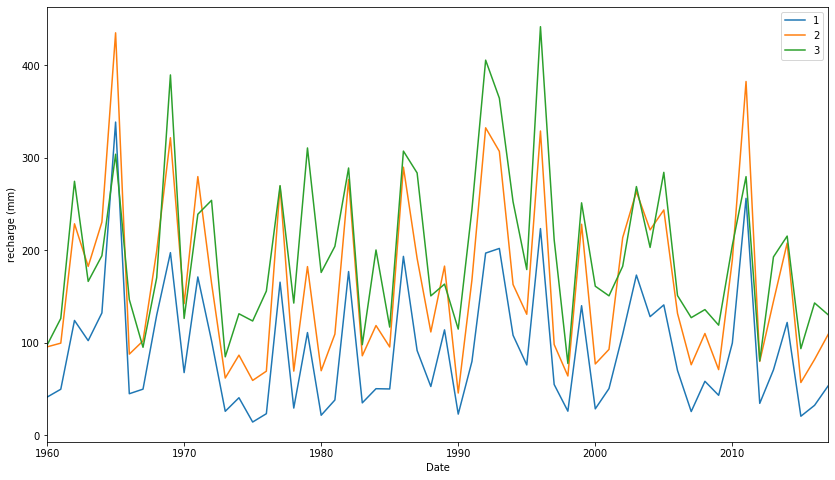

In [10]:
plt.figure(figsize=(14,8))
rech[rech["zone"]==1].groupby(rech[rech["zone"]==1].index.year).sum()["Recharge (mm)"].plot(label=1)
rech[rech["zone"]==2].groupby(rech[rech["zone"]==2].index.year).sum()["Recharge (mm)"].plot(label=2)
rech[rech["zone"]==3].groupby(rech[rech["zone"]==3].index.year).sum()["Recharge (mm)"].plot(label=3)
plt.legend()
plt.ylabel("recharge (mm)")


In [65]:
# recharge moyenne par zone
rech.groupby(["zone",rech.index.year]).sum().unstack().mean(axis=1)

zone
1     93.813318
2    164.209766
3    197.645383
dtype: float64

In [68]:
shp_zones = "../../data/recharge/zone_rch.tif"

MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

delc=np.ones([250])*300
delr = np.ones([250])*300

grid = flopy.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

In [69]:
zonrch = Raster.load(shp_zones)
zon_arr = zonrch.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)
rcha = zon_arr
year = 2013

for z in range(1,4):
    data = rech[rech["zone"]==z]

    rchy = data.groupby([data.index.year]).sum().loc[year]["Recharge (mm)"]

    rcha[zon_arr==z] = rchy
rcha[rcha==0]=np.mean(rcha[rcha!=0])

In [171]:
# by month
data.groupby([data.index.year,data.index.month]).sum().loc[1968,1]["Recharge (mm)"]

3.0060769018795583

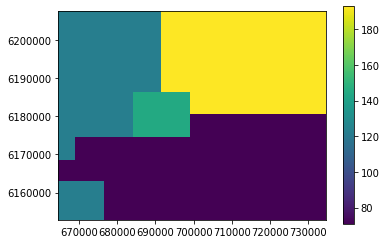

In [72]:
plt.imshow(rcha,extent=[x0,x1,y0,y1])
plt.colorbar()

In [154]:
write_pickle("../../data/recharge/rech_zones",rech)